In [8]:
import pandas as pd
from datetime import datetime
from sklearn.svm import OneClassSVM
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [9]:
window_sizes = [32, 64, 128, 256, 512, 1024] # 512 is around minute
contamination_factors = [0.01, 0.02, 0.03, 0.04, 0.05]

In [10]:
df = pd.read_csv("data/finnhub2h.csv")
columns = ["price", "volume", "trade_ts"]
timestamp_format = "%Y-%m-%d %H:%M:%S.%f%z"
df = df[columns]
df["trade_ts"] = df["trade_ts"].apply(lambda x: datetime.strptime(x, timestamp_format))
df = df.set_index("trade_ts")

size_of_df = len(df)

In [11]:
print(df.describe())
print(df.info())

              price        volume
count   58419.00000  58419.000000
mean   101381.63425      0.016505
std       356.57938      0.068510
min    100530.07000      0.000010
25%    101110.26000      0.000240
50%    101428.01000      0.000980
75%    101700.00000      0.005990
max    101898.00000      6.602400
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58419 entries, 2024-12-06 20:15:19.022000+00:00 to 2024-12-06 21:46:38.768000+00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   58419 non-null  float64
 1   volume  58419 non-null  float64
dtypes: float64(2)
memory usage: 1.3 MB
None


C:\Users\seksc\AppData\Local\Temp\ipykernel_23892\1890411308.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


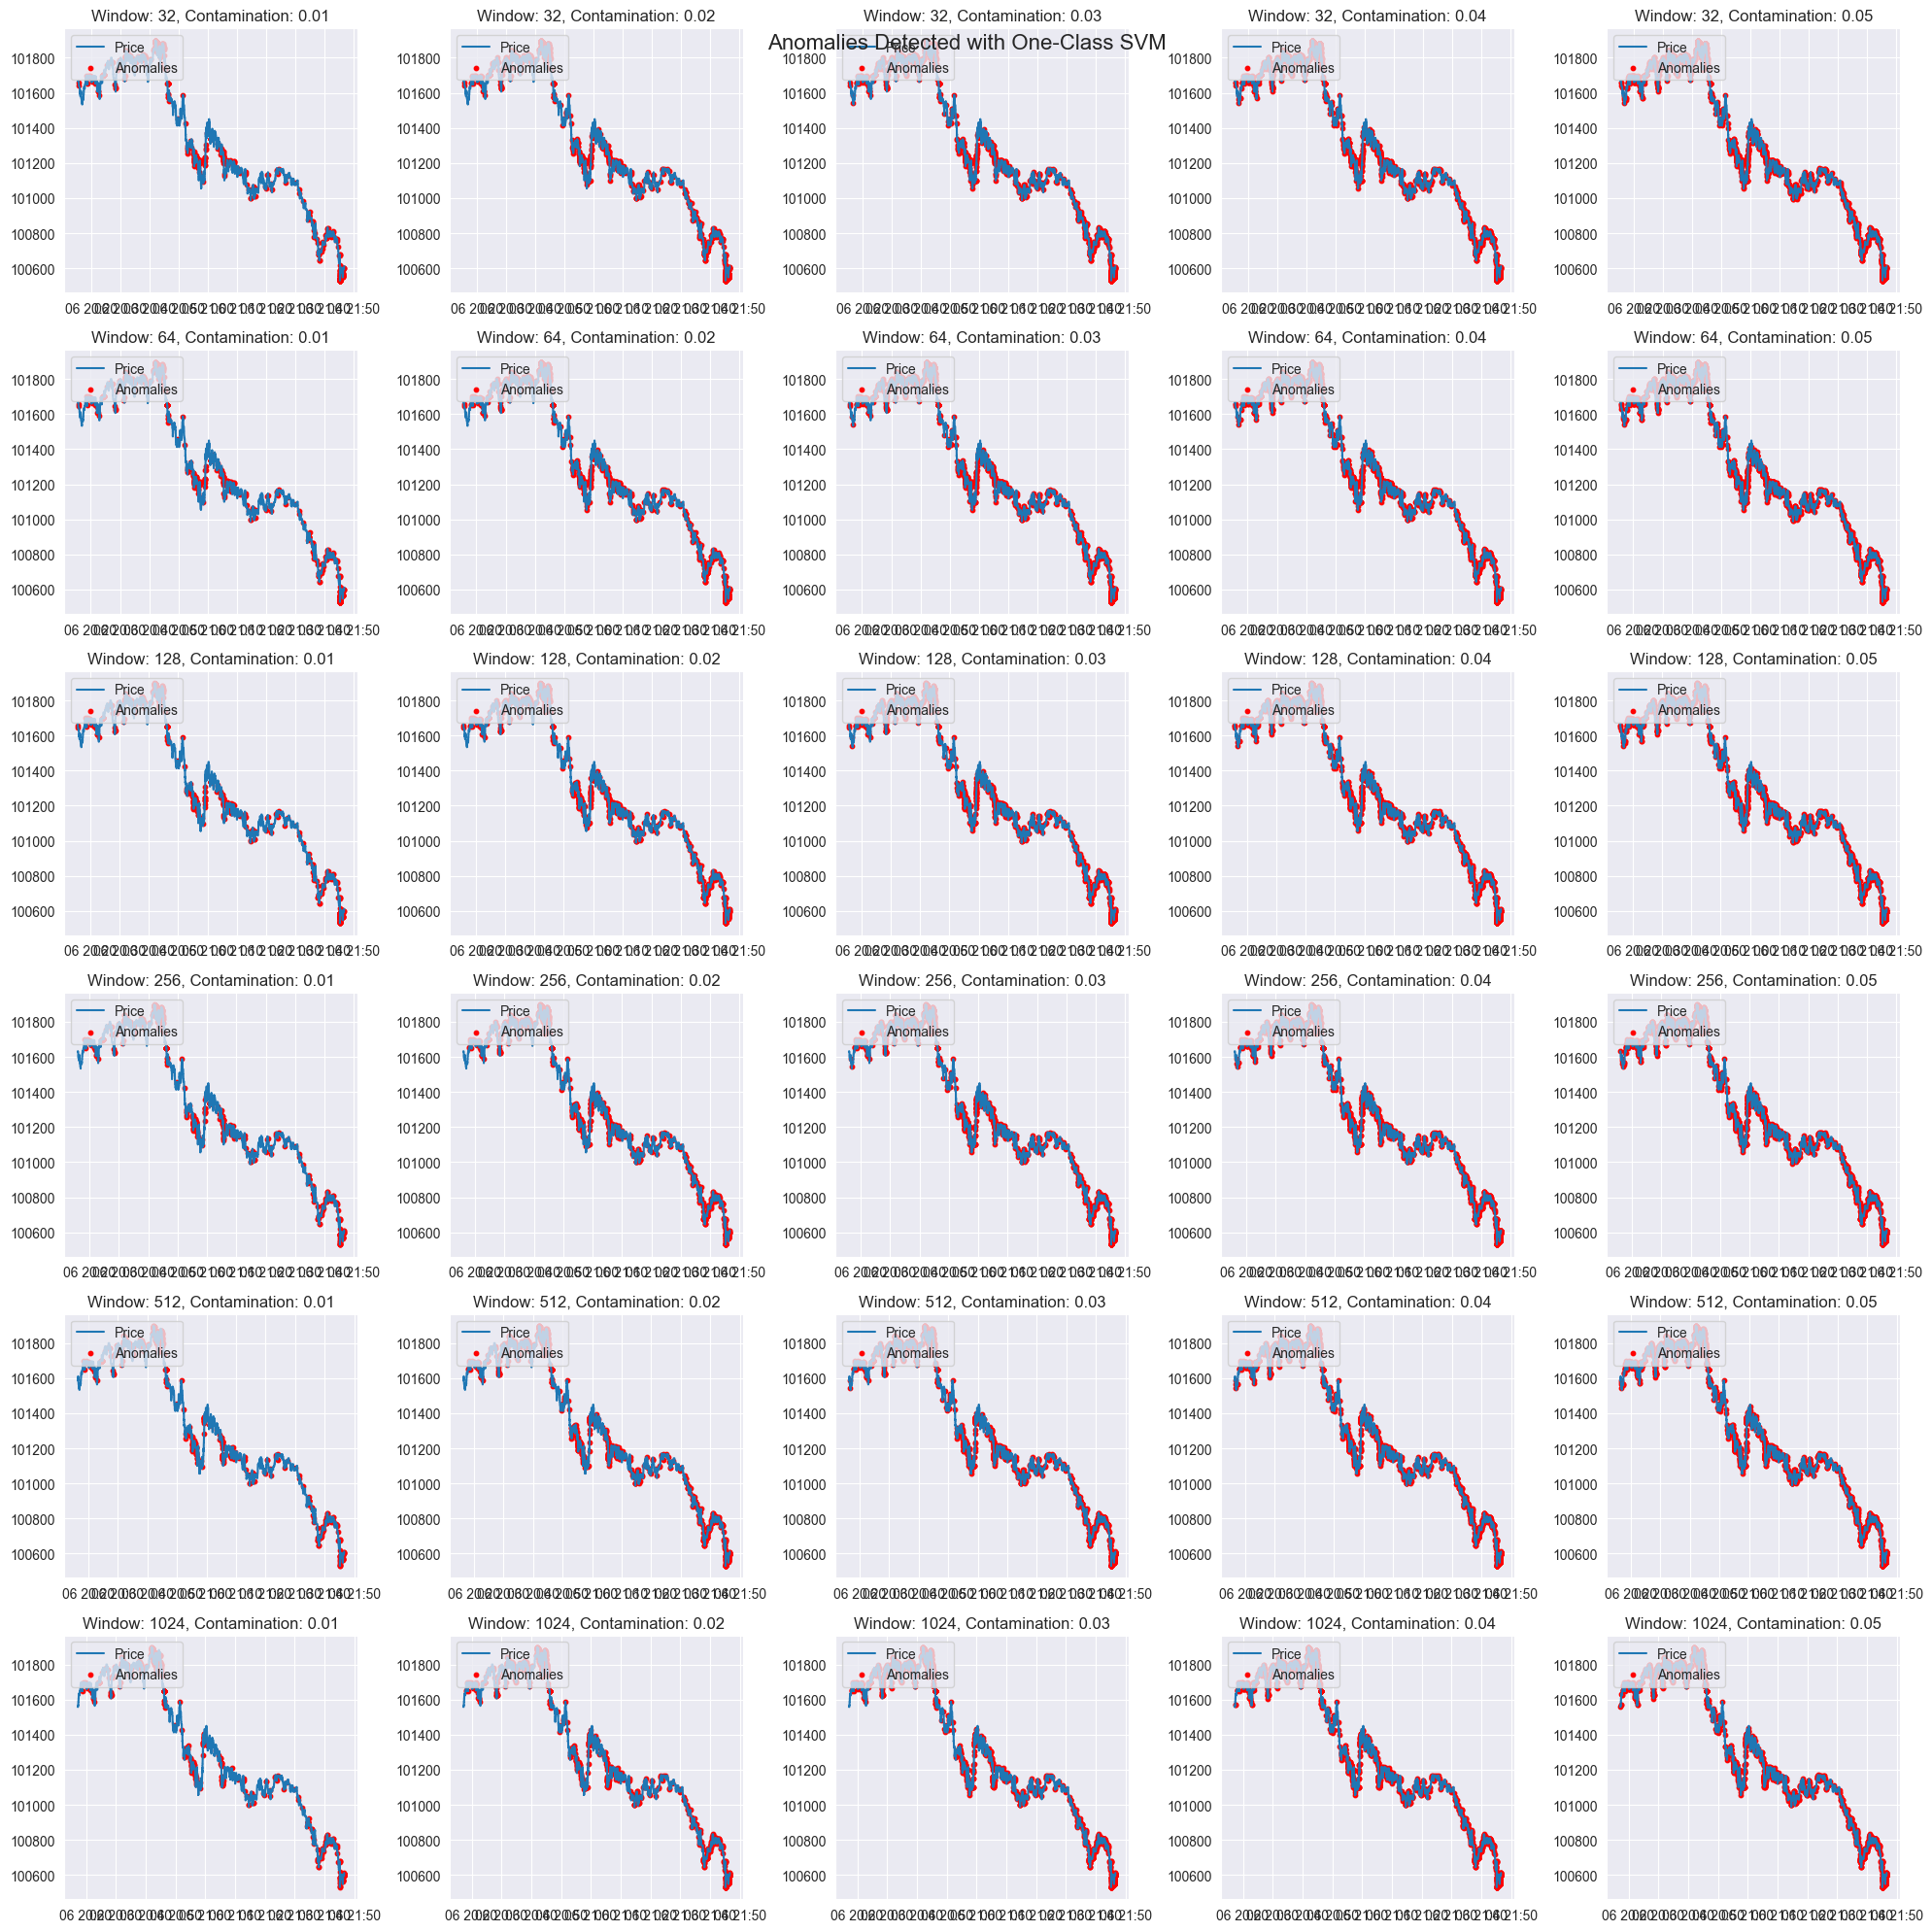

In [12]:
fig, axes = plt.subplots(len(window_sizes), len(contamination_factors), figsize=(20, 20), constrained_layout=True)

for i, window in enumerate(window_sizes):
    # Prepare rolling windows
    sampled_df = df.copy()
    sampled_df["rolling_mean"] = sampled_df["price"].rolling(window=window).mean()
    sampled_df = sampled_df.dropna()  # Drop NaN values from the rolling window calculation

    # Normalize the features
    features = sampled_df[["rolling_mean", "volume"]].values  # Include price and volume in feature space
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    for j, contamination in enumerate(contamination_factors):
        # Train the One-Class SVM
        svm = OneClassSVM(nu=contamination, kernel="rbf", gamma="scale")
        sampled_df["anomaly"] = svm.fit_predict(features)

        # Extract anomalies (anomalies are labeled as -1)
        anomalies = sampled_df[sampled_df["anomaly"] == -1]

        # Plotting
        ax = axes[i, j]
        ax.plot(sampled_df.index, sampled_df["price"], label="Price")
        ax.scatter(anomalies.index, anomalies["price"], color="red", label="Anomalies", s=10)

        # Add titles and labels
        ax.set_title(f"Window: {window}, Contamination: {contamination}")
        ax.legend(loc="upper left")
        ax.grid(True)

# Finalize and show the plot
plt.tight_layout()
plt.suptitle("Anomalies Detected with One-Class SVM", fontsize=16)
plt.show()